In [2]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from sklearn.datasets import fetch_openml
from tqdm import trange
import numpy as np
import random
import os

WAY = 5
SHOT = 1200
NUM_LABELS = 10
NUM_CLIENTS = 10

DATA_ROOT = '/data/privacyGroup/liujunxu/datasets/mnist/'
RES_ROOT = '../metadata/'

if not os.path.exists(RES_ROOT):
    os.makedirs(RES_ROOT)

train_data = MNIST(DATA_ROOT, train=True, download=True, 
                transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
test_data = MNIST(DATA_ROOT, train=False, download=True, 
                transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
data, target = train_data.data, train_data.targets
print(data.shape, target.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])


In [3]:
# data = np.concatenate([data], axis=0)
# target = np.concatenate([target], axis=0)
# print(data.shape, target.shape)

data_tr, data_ts = [], []
target_tr, target_ts = [], []

for i in range(NUM_LABELS):
    idx = target==i
    data_tr.append(list(data[idx]))
    target_tr.append(list(target[idx]))

# num_samples of each label
print([len(v) for v in data_tr])
print(type(data_tr[0][0]))

# [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
# <class 'numpy.ndarray'>

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
<class 'torch.Tensor'>


将原数据集合进行分割

1. 共`num_users`个clients，取部分作为train clients，剩下的作为test clients；
2. 用一个长度为10的指针数组`idx`，记录每个label已经被“assign”的样本数（或者说下次取samples的时候从哪个位置开始取）
3. 每个clients首先分到`n-way k-shot`个samples；
4. 进一步，每个clients将会分到`n-way`随机数量的samples，这个随机数服从mu=0,sigma=2的对数正态分布；

In [4]:
# shards 表示要将全部数据分成多少份
# 假设每个Client会应分到 N_WAY 份（N个不同labels，共 N*NUM_CLIENTS 份)
# 每份包含 60000 // N // NUM_CLIENTS 个样本
NUM_SHARDS = NUM_CLIENTS * WAY 
NUM_SHARDS_PER_LABEL = len(data) // NUM_LABELS // SHOT
print(NUM_SHARDS, NUM_SHARDS_PER_LABEL)

50 5


In [5]:
# assign
# label_count = [0] * NUM_LABELS
# np.random.seed(100) # seed 很重要
"""
WAY = 2 SHOT=1500 NUM_USERS = 20
num_shards = 20 * 2 = 40
SHARDS_PER_LABEL = 6000 / 1500 = 4
39 // 4 = 9
"""
while(True):
    ###### SPLIT DATA #######
    X = [[] for _ in range(NUM_CLIENTS)]
    y = [[] for _ in range(NUM_CLIENTS)]

    # 长度为10的数组: 指示每个标签已分配出去的样本数
    idx = np.zeros(NUM_LABELS, dtype=np.int64)
    shards_index = list(range(NUM_SHARDS))
    user_labels_count = {i: [] for i in range(NUM_CLIENTS)}
    FINDED = True
    for user in range(NUM_CLIENTS):
        if user == NUM_CLIENTS-1:
            rand_set = set(shards_index)
            labels = [idx // NUM_SHARDS_PER_LABEL for idx in rand_set]
            if len(set(labels)) < WAY:
                print('Failed!')
                FINDED = False
                break
        
        else:
            trials = 0
            while(True):
                rand_set = set(np.random.choice(shards_index, WAY, replace=False))
                if len(rand_set) > WAY: 
                    continue

                labels = [idx // NUM_SHARDS_PER_LABEL for idx in rand_set] # 
                if len(set(labels)) == WAY:
                    break
                trials += 1
                if trials > 100:
                    print('trials > 100, NOT FINDED.')
                    FINDED = False
                    break
        
        if FINDED == False:
            break

        shards_index = list(set(shards_index) - rand_set) # update shards_index
        # print(labels)
        for idx_lbl, lbl in enumerate(labels): # assign samples for the current user
    #         print(lbl, idx[lbl], idx[lbl]+SHOT)
            if len(X[user]) == 0:
                X[user] = data_tr[lbl][idx[lbl]:idx[lbl]+SHOT]
                y[user] = [lbl] * SHOT
                idx[lbl] += SHOT # 记录当前标签已分配的样本数
                print(user)
                print(type(X[user][0]))
            else:
                X[user].extend(data_tr[lbl][idx[lbl]:idx[lbl]+SHOT])
                print(type(X[user][-1]))
                y[user].extend([lbl] * SHOT)
                idx[lbl] += SHOT # 记录当前标签已分配的样本数
            
        print(user, np.unique(y[user]))
    
    if FINDED:
        break
    #     print(idx)

0
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
0 [1 5 6 7 9]
1
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
1 [0 3 4 6 8]
2
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
2 [0 3 4 5 7]
3
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
3 [1 4 5 6 8]
4
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
4 [0 2 3 6 7]
5
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
5 [1 2 6 8 9]
6
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
6 [3 5 7 8 9]
7
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torc

In [8]:
from tqdm import tqdm
# Create data structure
federated_data = {'users': [], 'user_data':{}, 'num_samples':[], 'classes':{}}
save_dir = f"./niid_{WAY}way_{SHOT}shot"
if not (os.path.exists(save_dir)):
    os.mkdir(save_dir)
    
for user in trange(NUM_CLIENTS, ncols=100):
    uname = 'client{:d}'.format(user) 
    combined = list(zip(X[user], y[user])) 
    random.shuffle(combined)
    print(uname, combined)
    np.save(os.path.join(save_dir, f"{uname}.npy"), combined)
    
#     # take 80% as train samples，the rest as test samples
#     train_len = int(0.8*len(combined))
#     test_len = len(combined) - train_len
#     print(uname, len(combined), train_len, test_len)
    
#     classes = {idx_lbl:int(lbl) for idx_lbl, lbl, _ in user_labels_count[i]}
    
#     train_data['users'].append(uname) 
#     train_data['user_data'][uname] = combined[:train_len]
#     train_data['num_samples'].append(train_len)
#     train_data['classes'][uname] = classes
    
#     test_data['users'].append(uname)
#     test_data['user_data'][uname] = combined[train_len:]
#     test_data['num_samples'].append(test_len)
#     test_data['classes'][uname] = classes
    


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

client0 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/home/wamdm/miniconda3/envs/liujunxu_tf1/lib/python3.7/site-packages/numpy/lib/npyio.py:528: Visib

client1 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20%|████████████▊                                                   | 2/10 [01:39<06:39, 50.00s/it]

client2 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|███████████████████▏                                            | 3/10 [02:30<05:52, 50.33s/it]

client3 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 30%|███████████████████▏                                            | 3/10 [03:05<07:12, 61.85s/it]


KeyboardInterrupt: 

In [ ]:
train_path = RES_ROOT + '/all_data_niid_train_{}way_{}shot_82_6000.npy'.format(WAY, SHOT)
test_path = RES_ROOT + '/all_data_niid_test_{}way_{}shot_82_6000.npy'.format(WAY, SHOT)
np.save(train_path, train_data)
np.save(test_path, test_data)

In [7]:
RES_ROOT = '/data/privacyGroup/liujunxu/datasets/mnist/type3'
train_path = RES_ROOT + '/all_data_niid_train_{}way_{}shot_82_6000.npy'.format(WAY, SHOT)
test_path = RES_ROOT + '/all_data_niid_test_{}way_{}shot_82_6000.npy'.format(WAY, SHOT)
train_data = np.load(train_path, allow_pickle=True).item()
test_data = np.load(test_path, allow_pickle=True).item()
type(train_data)

dict

ValueError: cannot reshape array of size 784 into shape (32,32,3)

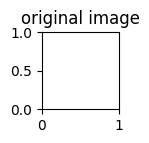

In [8]:
import matplotlib.pyplot as plt
# import matplotlib as plt
cid = test_data['users'][2]
imageid = 4
test_samples = test_data['user_data'][cid]
# # print(test_samples[1][0].shape)
# plt.figure(1)
# plt.imshow(test_samples[imageid][0]) # 使用matplotlib显示彩色图像需要数据的维度为 [W, H, C]，就是224 * 224 * 3
# plt.show()
# print(test_samples[imageid][1])

plt.figure(figsize=(1,1))
plt.subplot(111)
plt.title('original image')
plt.imshow(np.array(test_samples[imageid][0]).reshape(28,28))


In [ ]:
# from torchvision.datasets import MNIST
# from torchvision.transforms import Compose, Normalize, ToTensor
# from sklearn.datasets import fetch_openml
# from tqdm import trange
# import numpy as np
# import random

# WAY = 5
# SHOT = 120
# NUM_LABELS = 10
# NUM_USERS = 100
# RES_ROOT = '/data/privacyGroup/liujunxu/datasets/mnist/type3'
# train_path = RES_ROOT + '/all_data_niid_train_55_6000.npy'.format(WAY, SHOT)
# test_path = RES_ROOT + '/all_data_niid_test_55_6000.npy'.format(WAY, SHOT)
# train_data = np.load(train_path, allow_pickle=True).item()
# test_data = np.load(test_path, allow_pickle=True).item()
# type(train_data)

In [ ]:
# import matplotlib.pyplot as plt
# # import matplotlib as plt
# cid = test_data['users'][4]
# imageid = 4
# test_samples = test_data['user_data'][cid]
# # # print(test_samples[1][0].shape)
# # plt.figure(1)
# # plt.imshow(test_samples[imageid][0]) # 使用matplotlib显示彩色图像需要数据的维度为 [W, H, C]，就是224 * 224 * 3
# # plt.show()
# # print(test_samples[imageid][1])

# plt.figure(figsize=(1,1))
# plt.subplot(111)
# plt.title('original image')
# plt.imshow(np.array(test_samples[imageid][0]).reshape(28,28,1))
# print(test_samples[imageid][1])